## La spiegazione di questo codice forse la metto forse no, sicuro fa riferimento a record_linkage

In [1]:
import recordlinkage
from recordlinkage import Compare
from recordlinkage.preprocessing import clean
import pandas as pd

companies_df = pd.read_csv('../aziende_normalizzate.csv')

### Stai attento peró che con l'approccio sotto riportato 2 righe matchano solo se entrambi i valori fanno match
### **Miglioramento del Blocking con la Città e il Paese**

# **Obiettivo**
Migliorare il processo di blocking per la deduplicazione dei dati aziendali, in modo da evitare che il numero totale di coppie candidate basato sulla città sia uguale a quello basato sul paese, e aggiungere coppie candidate solo quando necessario.

## **Passaggi:**

### 1. **Separazione dei Dati in Base alla Città**
   - Prima di eseguire il blocking sulla città, dividiamo il DataFrame in due subset:
     - `df_non_null_city`: Contiene solo le righe con valori non nulli nella colonna `city`.
     - `df_null_city`: Contiene solo le righe con valori nulli nella colonna `city`.

### 2. **Blocking Sulla Città**
   - Utilizziamo `recordlinkage.Index()` per eseguire il blocking sulla colonna `city` e generare le coppie candidate per le aziende con la stessa città.

### 3. **Aggiunta delle Coppie Candidate sulla Base del Paese**
   - Dopo aver creato le coppie sulla base della città, eseguiamo un ulteriore controllo:
     - Se le città delle coppie candidate non corrispondono o sono nulle, eseguiamo il blocking sulla colonna `country`.
     - Le coppie basate sul paese vengono aggiunte solo se non sono già presenti nelle coppie generate dal blocking sulla città, evitando duplicazioni.

### 4. **Uso di un Set per Evitare Duplicati**
   - Utilizziamo un `set` per le coppie finali per garantire che non ci siano duplicati, dato che un set non permette voci ripetute.
   - Alla fine, converte il `set` in una lista per restituire il risultato finale.

### 5. **Risultati**
   - Il risultato finale sarà un elenco di coppie candidate che sono uniche, combinando il blocking basato sulla città e sul paese solo quando necessario, senza duplicati.

Con questo approccio, otteniamo un numero di coppie candidate basato su una logica più efficiente, riducendo i duplicati e migliorando la qualità dei dati per la fase di matching.


In [2]:
def block_city_or_country(df):
    indexer = recordlinkage.Index()

    df_non_null_city = df.dropna(subset=['city'])
    df_null_city = df[df['city'].isnull()]

    # Creazione delle coppie basate sulla città
    indexer.block(left_on=['city'])
    candidate_pairs_city = indexer.index(df_non_null_city)
    print(f'Numero di coppie candidate sulla città: {len(candidate_pairs_city)}')

    candidate_pairs_final = set(candidate_pairs_city)

    # Aggiungi coppie basate sul paese solo se le città sono diverse o nulle
    for idx_left, idx_right in candidate_pairs_city:
        city_left = df.loc[idx_left, 'city']
        city_right = df.loc[idx_right, 'city']
        
        if city_left != city_right or pd.isnull(city_left) or pd.isnull(city_right):
            indexer = recordlinkage.Index()
            indexer.block(left_on=['country'])
            candidate_pairs_country = indexer.index(df)

            for country_pair in candidate_pairs_country:
                # Aggiungi la coppia solo se non è già presente nelle coppie candidate
                if (idx_left, idx_right) == country_pair:
                    candidate_pairs_final.add(country_pair)

    return list(candidate_pairs_final)

candidate_pairs = block_city_or_country(companies_df)
print(f'Numero totale di coppie candidate: {len(candidate_pairs)}')



Numero di coppie candidate sulla città: 3693056
Numero totale di coppie candidate: 3693056


In [4]:
candidate_pairs_index = pd.MultiIndex.from_tuples(candidate_pairs, names=['left', 'right'])

companies_df = companies_df.reset_index(drop=True)

companies_df = companies_df.fillna("")

if companies_df['foundation_year'].dtype != 'int64':
    companies_df['foundation_year'] = pd.to_numeric(companies_df['foundation_year'], errors='coerce').fillna(0).astype(int)

if companies_df['number_of_employees'].dtype != 'int64':
    companies_df['number_of_employees'] = pd.to_numeric(companies_df['number_of_employees'], errors='coerce').fillna(0).astype(int)

compare = Compare()
compare.numeric('foundation_year', 'foundation_year', label='foundation_year')

compare.string('categories', 'categories', method='jarowinkler', threshold=0.85, label='categories')
compare.string('company_status', 'company_status', method='jarowinkler', threshold=0.85, label='company_status')
compare.string('website', 'website', method='jarowinkler', threshold=0.85, label='website')
compare.string('sector', 'sector', method='jarowinkler', threshold=0.85, label='sector')
compare.string('trade_name', 'trade_name', method='jarowinkler', threshold=0.85, label='trade_name')
compare.string('company_type', 'company_type', method='jarowinkler', threshold=0.95, label='company_type')
compare.string('rank', 'rank', method='jarowinkler', threshold=0.85, label='rank')
compare.numeric('number_of_employees', 'number_of_employees', label='number_of_employees')

try:
    features = compare.compute(candidate_pairs_index, companies_df)
    display(features.head(10))
except Exception as e:
    print("Errore durante il calcolo delle feature sull'intero dataset:", e)

foundation_year  categories  company_status  website  sector  \
left  right                                                                 
4319  7                  1.0         0.0             0.0      0.0     0.0   
6600  7                  1.0         0.0             0.0      1.0     0.0   
      4319               1.0         0.0             0.0      0.0     0.0   
13081 7                  1.0         0.0             0.0      1.0     0.0   
      4319               1.0         0.0             0.0      0.0     0.0   
      6600               1.0         0.0             0.0      1.0     0.0   
13082 7                  1.0         0.0             0.0      1.0     0.0   
      4319               1.0         0.0             0.0      0.0     0.0   
      6600               1.0         0.0             0.0      1.0     0.0   
      13081              1.0         0.0             0.0      1.0     0.0   

             trade_name  company_type  rank  number_of_employees  
left  right                                                       
4319  7             0.0           0.0   0.0                  0.0  
6600  7             0.0           0.0   0.0                  1.0  
      4319          0.0           0.0   0.0                  0.0  
13081 7             0.0           0.0   0.0                  1.0  
      4319          0.0           0.0   0.0                  0.0  
      6600          0.0           0.0   0.0                  1.0  
13082 7             0.0           0.0   0.0                  1.0  
      4319          0.0           0.0   0.0                  0.0  
      6600          0.0           0.0   0.0                  1.0  
      13081         1.0           0.0   0.0                  1.0

In [7]:
matches = features[features.sum(axis=1) > 3]

print(f'Numero di corrispondenze trovate: {len(matches)}')

matches.head()

Numero di corrispondenze trovate: 26953


foundation_year  categories  company_status  website  sector  \
left  right                                                                 
13082 13081              1.0         0.0             0.0      1.0     0.0   
10870 2037               1.0         0.0             0.0      1.0     1.0   
18102 17135              1.0         0.0             0.0      0.0     1.0   
23093 2037               0.5         0.0             0.0      1.0     1.0   
      10870              0.5         0.0             0.0      1.0     1.0   

             trade_name  company_type  rank  number_of_employees  
left  right                                                       
13082 13081         1.0           0.0   0.0                  1.0  
10870 2037          0.0           0.0   0.0                  1.0  
18102 17135         0.0           1.0   0.0                  1.0  
23093 2037          0.0           0.0   0.0                  1.0  
      10870         0.0           0.0   0.0                  1.0

In [8]:
grouped_matches = matches.loc[matches.sum(axis=1).groupby(level=0).idxmax()]

grouped_matches.head(100)

,,foundation_year,categories,company_status,website,sector,trade_name,company_type,rank,number_of_employees
left,right,,,,,,,,,
13,12,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
590,121,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
677,639,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
715,167,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
783,757,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
4644,4596,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4667,2335,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4671,334,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [9]:
import networkx as nx

def merge_values(series):
    unique_values = set(series.dropna()) 
    return ' | '.join(map(str, unique_values)) if len(unique_values) > 0 else ''  
G = nx.Graph()
G.add_edges_from(grouped_matches.index.tolist())

connected_components = list(nx.connected_components(G))

duplicate_groups = {node: i for i, component in enumerate(connected_components) for node in component}

companies_df['group_id'] = companies_df.index.map(duplicate_groups)

def print_aggregated_rows(group_id, group_data):
    if len(group_data) >= 3:  
        print(f"\nAggregazione del gruppo {group_id} (con {len(group_data)} elementi):")
        group_data = group_data.reset_index()  
        print(group_data[['company_name', 'city', 'country', 'address']])  

final_df = companies_df.groupby('group_id').agg(merge_values).reset_index()

final_df = final_df.drop(columns=['group_id'])

for group_id, group_data in companies_df.groupby('group_id'):
    print_aggregated_rows(group_id, group_data)

final_df.to_csv("deduplicated_companies2.csv", index=False)

display(final_df.head())


Aggregazione del gruppo 1.0 (con 19 elementi):
                 company_name    city country address
0                 3i infotech  mumbai   india        
1           abm knowledgeware  mumbai   india        
2                agc networks  mumbai   india        
3              allied digital  mumbai   india        
4                   aurionpro  mumbai   india        
5           datamatics global  mumbai   india        
6                       edocs  mumbai   india        
7       genesys international  mumbai   india        
8       hexaware technologies  mumbai   india        
9       itsource technologies  mumbai   india        
10                lt infotech  mumbai   india        
11                 mahaonline  mumbai   india        
12                     mastek  mumbai   india        
13                     nse.it  mumbai   india        
14           onward eservices  mumbai   india        
15  oracle financial software  mumbai   india        
16                rolta india  mum

,company_id,company_name,trade_name,industry,sector,categories,company_status,company_type,address,postal_code,...,emtak_code,nace_code,facebook,twitter,pinterest,instagram,investors,region,notes_or_description,modified
0,3694 | 1804,1-800-flowers.com,1-800-flowers.com,,,,,,2 jericho plz ste 200,117531681,...,,,,,,,,,headquarter,False
1,,edocs | rolta india | uti | mahaonline | genes...,,it services & consulting,it services & consulting,,,public,,,...,,,,,,,,,,True
2,,g-cube | indiacan | absas | paperpedia | extra...,,edtech,edtech,,,private,,,...,,,,,,,,,,True
3,,object frontier software | imarque | miramed a...,,it services & consulting,it services & consulting,,,private,,,...,,,,,,,,,,True
4,,qentelli | hitachi consulting | o9 | slk globa...,,it services & consulting,it services & consulting,,,private,,,...,,,,,,,,,,True


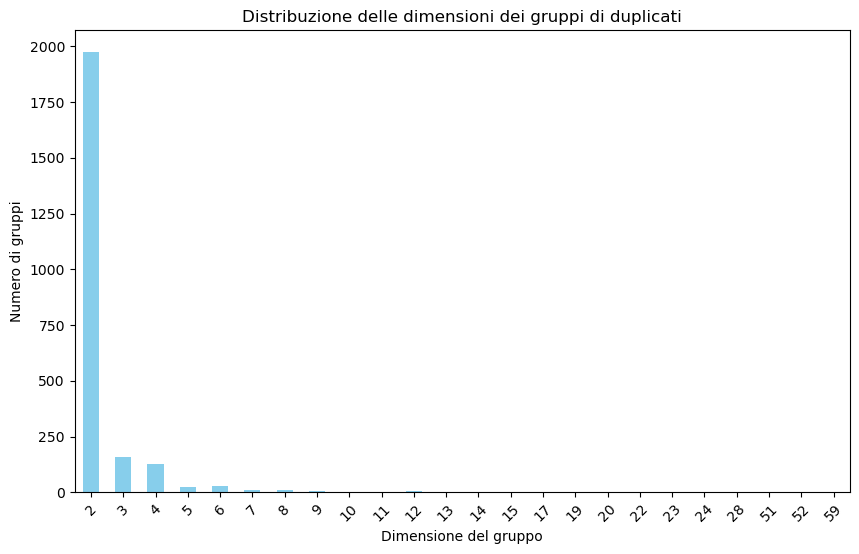

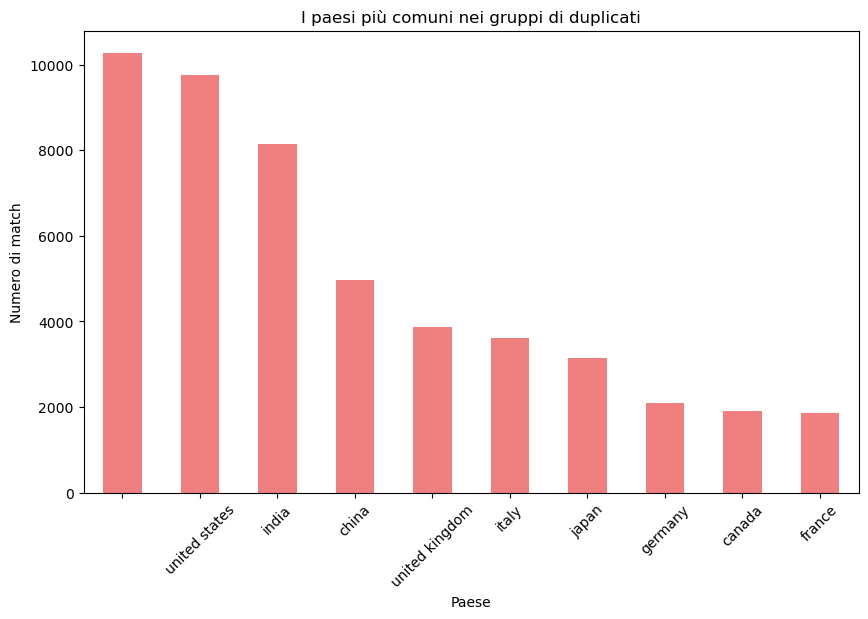

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


group_sizes = companies_df.groupby('group_id').size()

group_sizes_filtered = group_sizes[group_sizes > 1]

plt.figure(figsize=(10, 6))
group_sizes_filtered.value_counts().sort_index().plot(kind='bar', color='skyblue')

plt.title('Distribuzione delle dimensioni dei gruppi di duplicati')
plt.xlabel('Dimensione del gruppo')
plt.ylabel('Numero di gruppi')
plt.xticks(rotation=45)
plt.show()


country_counts = companies_df['country'].value_counts()
plt.figure(figsize=(10, 6))
country_counts.head(10).plot(kind='bar', color='lightcoral')
plt.title('I paesi più comuni nei gruppi di duplicati')
plt.xlabel('Paese')
plt.ylabel('Numero di match')
plt.xticks(rotation=45)
plt.show()